# Chapter 2 Multi-armed Bandits

implementing Prof. Sutton's Reinforcement Learning book contents in python and tensorflow

# 2.3 The 10-armed Testbed

## Figure 2.1
An example bandit problem from the 10-armed testbed. The true value q∗(a) of each of the ten actions was selected according to a normal distribution with mean zero and unit variance, and then the actual rewards were selected according to a mean q∗(a) unit variance normal distribution, as suggested by these gray distributions.

In [1]:
# common imports

import matplotlib.pyplot as plt
import numpy as np
import pickle as pk
import datetime as dt

# declare bandit arm numbers
k = 10

In [2]:
# Figure 2.1

def draw_bandits(q_stars, r_dist, mean=0.0) :
    k = len(q_stars)
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    # plot violin plot
    ax.violinplot(r_dist,
                showmeans=False,
                showmedians=True,
                showextrema=False,
                widths=0.3)

    # ax.set_title('Figure 2.1')
    ax.set_xticks([t + 1 for t in range(k)])
    ax.set_xticklabels([t + 1 for t in range(k)])
    for t in range(k) :
        ax.text(t + 1, q_stars[t], 'q*(' + str(t + 1) + ')')

    ax.set_xlabel('Action')
    ax.set_ylabel('Reward distribution')

    ax.plot([0.5, 10.5], [mean, mean], linestyle='--', linewidth=1)
    plt.show()


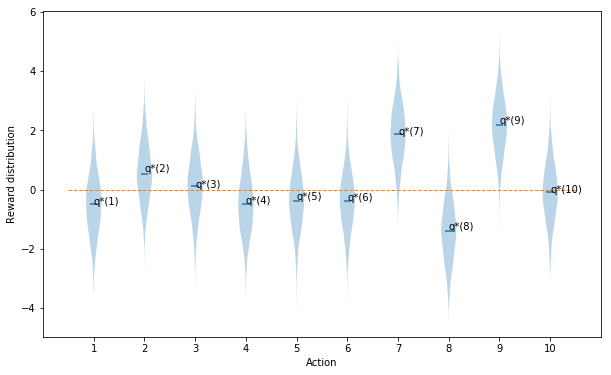

In [43]:
# Fixing random state for reproducibility
np.random.seed(9999)

# create and save bandit machines

# q_stars will be the action value of each lever selection (now, bandit machine is made !!!)
q_stars = [ np.random.normal() for a in range(k) ]

r_dist = [np.random.normal(q_stars[t], 1.0, 2000) for t in range(k)]

# save generated bandit
pk.dump((q_stars, r_dist), open('10-armed.p', "wb" ))

draw_bandits(q_stars, r_dist)

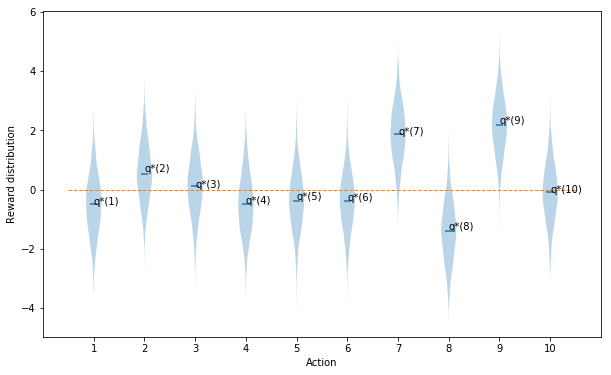

In [3]:
import pickle as pk

# load saved bandit machines

q_stars, r_dist = pk.load(open('10-armed.p', "rb"))

draw_bandits(q_stars, r_dist)

## Figure 2.2
Average performance of ε-greedy action-value methods on the 10-armed testbed. These data are averages over 2000 runs with different bandit problems. All methods used sample averages as their action-value estimates.

In [4]:
# Figure 2.2

time_steps = 1000

def generate_distributed_random_integers(low, high, size) :
    partition = (high - low) // size
    return [ low + (partition) * i + np.random.randint(0, partition) for i in range(size) ]
    
def select_greedy(values) :
    indices = np.concatenate(np.where(values == values.max()))
    if len(indices) > 1 : # if we remember prev decision, then we can optimize to select by round-robin
        idx = np.random.randint(0, len(indices))
        return indices[idx]
    return indices[0]
    
def single_run(k, q_stars, r_dist, action_policy='greedy', arg=0.0) :    
    # initialize
    n_taken = np.zeros(k, np.int32)
    values = np.zeros(k, np.float32)
    sum_rewards = np.zeros(k, np.float32)

    epsilon = arg if arg is not None else 0.1 # e-greedy epsilon
    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)

    if False :
        # bandit state simulation. pre-determine each time step states for calculation performance
        bandit_trials = np.stack([np.random.normal(q_stars[i], 1.0, time_steps) for i in range(k)])
    else :
        # choose bandit state from pre-calculated 2000 cases
        bandit_trials = np.stack([r_dist[:, np.random.randint(0, r_dist.shape[1])] for _ in range(time_steps)])
        bandit_trials = np.transpose(bandit_trials)

    #explore_count = 0
    optimal_count = 0
    if action_policy == 'e-greedy' :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * epsilon))

    for t in range(time_steps) :
        # action selection by policy
        if action_policy == 'e-greedy' :
            if t in explore_steps :
                # explore_count = explore_count + 1
                lever = np.random.randint(0, k)
            else :
                lever = select_greedy(values)
        else : # default is greedy
            lever = select_greedy(values)
        reward = bandit_trials[lever, t]
        
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        n_taken[lever] = n_taken[lever] + 1
        
        # calculate action-values by sample_average method
        sum_rewards[lever] = sum_rewards[lever] + reward
        values[lever] = sum_rewards[lever] / n_taken[lever]
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

In [29]:
num_run = 2000

avg_rs_e0 = np.empty(num_run, dtype=object)
avg_rs_e01 = np.empty(num_run, dtype=object)
avg_rs_e001 = np.empty(num_run, dtype=object)
opt_acts_e0 = np.empty(num_run, dtype=object)
opt_acts_e01 = np.empty(num_run, dtype=object)
opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    avg_rs_e0[i], opt_acts_e0[i] = single_run(k, q_stars, nr_dist, action_policy='greedy')
    avg_rs_e01[i], opt_acts_e01[i] = single_run(k, q_stars, nr_dist, action_policy='e-greedy', arg=0.1)
    avg_rs_e001[i], opt_acts_e001[i] = single_run(k, q_stars, nr_dist, action_policy='e-greedy', arg=0.01)
    
print('finished running bandits :', dt.datetime.now())

starts running bandits : 2018-07-21 22:26:14.431747
finished running bandits : 2018-07-21 22:30:26.314125


In [30]:
# get average of the 2000 runs

m_avg_rs_e0 = np.mean(np.stack(avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(opt_acts_e001), axis=0)

In [18]:
# draw steps - average reward

def draw_step_reward(time_steps) :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    x_interval = time_steps // 4
    ax.set_xticks([x for x in range(0, time_steps, x_interval)])
    ax.set_xticklabels([x for x in range(0, time_steps, x_interval)])

    x_axis = np.array(range(1, time_steps))
    ax.plot(x_axis, m_avg_rs_e0[1:], color='g', lw=0.8, label='greedy')
    ax.text(500, m_avg_rs_e0[500] + 0.1, 'e=0 (greedy)', color='g')

    ax.plot(x_axis, m_avg_rs_e01[1:], color='b', lw=0.8, label='e-greedy (e=0.1)')
    ax.text(200, m_avg_rs_e01[200] + 0.1, 'e=0.1', color='b')

    ax.plot(x_axis, m_avg_rs_e001[1:], color='r', lw=0.8, label='e-greedy (e=0.01)')
    ax.text(900, m_avg_rs_e001[900] + 0.1, 'e=0.01', color='r')

    ax.set_xlabel('Steps')
    ax.set_ylabel('Average reward')

    plt.show()


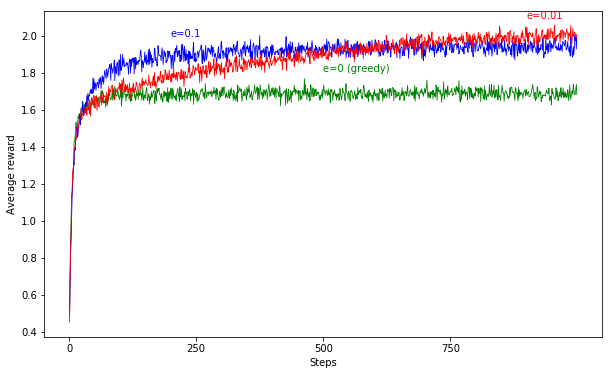

In [31]:
draw_step_reward(time_steps)

In [19]:
# draw steps - optimal action

def draw_step_optimal_action(time_steps) :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    x_interval = time_steps // 4
    ax.set_xticks([x for x in range(0, time_steps, x_interval)])
    ax.set_xticklabels([x for x in range(0, time_steps, x_interval)])

    x_axis = np.array(range(1, time_steps + 1))
    ax.plot(x_axis, m_opt_acts_e0, color='g', lw=0.8, label='greedy')
    ax.text(500, m_opt_acts_e0[500], 'e=0 (greedy)', color='g')

    ax.plot(x_axis, m_opt_acts_e01, color='b', lw=0.8, label='e-greedy (e=0.1)')
    ax.text(200, m_opt_acts_e01[200], 'e=0.1', color='b')

    ax.plot(x_axis, m_opt_acts_e001, color='r', lw=0.8, label='e-greedy (e=0.01)')
    ax.text(900, m_opt_acts_e001[900], 'e=0.01', color='r')

    ax.set_xlabel('Steps')
    ax.set_ylabel('Optimal action')

    plt.show()


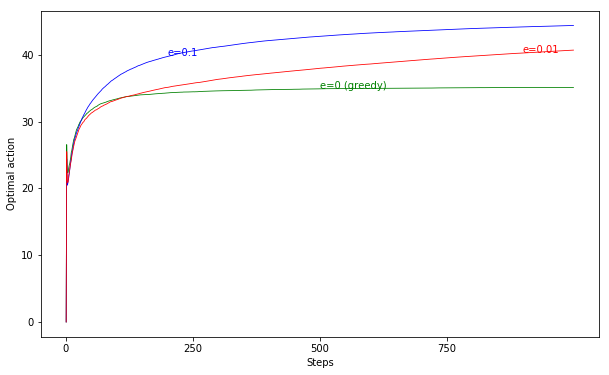

In [32]:
draw_step_optimal_action(time_steps)

# 2.4 Incremental Implementation

## A simple bandit algorithm

In [33]:
# A simple bandit algorithm

def incremental_single_run(k, q_stars, r_dist, action_policy='greedy', arg=0.0) :    
    # initialize
    n_taken = np.zeros(k, np.int32) # N(a) in the text
    # sum_rewards = np.zeros(k, np.float32) # removed from the sample-average method
    values = np.zeros(k, np.float32) # Q(a) in the text

    epsilon = arg if arg is not None else 0.1 # e-greedy epsilon
    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)

    # choose bandit state from pre-calculated 2000 cases
    bandit_trials = np.transpose(np.stack([r_dist[:, np.random.randint(0, r_dist.shape[1])] for _ in range(time_steps)]))

    # explore_count = 0
    optimal_count = 0
    if action_policy == 'e-greedy' :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * epsilon))

    for t in range(time_steps) :
        # action selection by policy
        if action_policy == 'e-greedy' :
            if t in explore_steps :
                # explore_count = explore_count + 1
                lever = np.random.randint(0, k)
            else :
                lever = select_greedy(values)
        else : # default is greedy
            lever = select_greedy(values)
        reward = bandit_trials[lever, t] # R <- bandit(A) in the text. A is the selected lever
        
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        n_taken[lever] = n_taken[lever] + 1 # N(A) <- N(A) + 1 in the text
        
        # calculate action-values by incremental method
        values[lever] = values[lever] + (reward - values[lever]) / n_taken[lever]
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

In [34]:
num_run = 2000

i_avg_rs_e0 = np.empty(num_run, dtype=object)
i_avg_rs_e01 = np.empty(num_run, dtype=object)
i_avg_rs_e001 = np.empty(num_run, dtype=object)
i_opt_acts_e0 = np.empty(num_run, dtype=object)
i_opt_acts_e01 = np.empty(num_run, dtype=object)
i_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    i_avg_rs_e0[i], i_opt_acts_e0[i] = incremental_single_run(k, q_stars, nr_dist,
                                                              action_policy='greedy')
    i_avg_rs_e01[i], i_opt_acts_e01[i] = incremental_single_run(k, q_stars, nr_dist,
                                                                action_policy='e-greedy', arg=0.1)
    i_avg_rs_e001[i], i_opt_acts_e001[i] = incremental_single_run(k, q_stars, nr_dist,
                                                                  action_policy='e-greedy', arg=0.01)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(i_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(i_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(i_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(i_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(i_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(i_opt_acts_e001), axis=0)


starts running bandits : 2018-07-21 22:30:26.850153
finished running bandits : 2018-07-21 22:34:06.931724


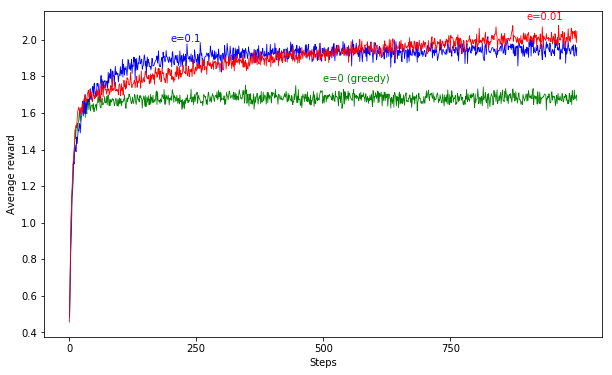

In [35]:
draw_step_reward(time_steps)

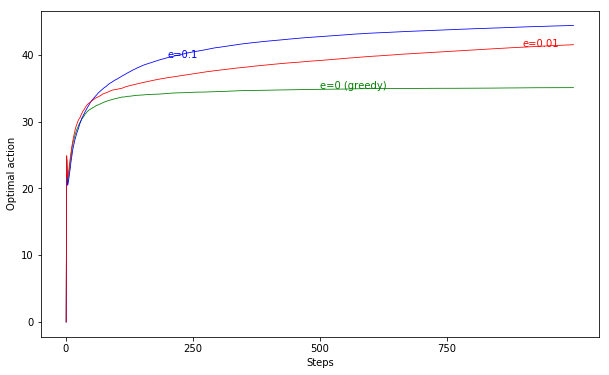

In [36]:
draw_step_optimal_action(time_steps)

# 2.5 Tracking a Nonstationary Problem

## Exercise 2.5

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q∗(a) start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the q∗(a) on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and longer runs, say of 10,000 steps.

In [10]:
# Exercise 2.5

def build_nonstationary_bandits(k, q_stars, r_dist, time_steps, std=0.01) :
    trials = np.empty(time_steps, dtype=object)
    trials[0] = r_dist[:, np.random.randint(0, r_dist.shape[1])]
    for t in range(1, time_steps) :        
        trials[t] = trials[t-1] + np.random.normal(0, std, k)
    return np.transpose(np.stack(trials))

def select_greedy2(values) :
    indices = np.concatenate(np.where(values == values.max()))
    if len(indices) > 1 : # if we remember prev decision, then we can optimize to select by round-robin
        idx = np.random.randint(0, len(indices))
        return indices[idx]
    elif len(indices) == 0 :
        raise ValueError('max does not exist for the values :' + str(values))
    return indices[0]

def nonstationary_run(k, q_stars, r_dist, time_steps, action_policy='greedy', method='incremental',
                      std=0.01, epsilon=0.0, step_size=0.0) :  
    # initialize
    n_taken = np.zeros(k, np.int32) # N(a) in the text
    values = np.zeros(k, np.float32) # Q(a) in the text
    if method == 'sample-average' :
        sum_rewards = np.zeros(k, np.float32)

    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)

    # nonstationary bandit state simulation.
    # pre-determine each time step states for calculation performance
    bandit_trials = build_nonstationary_bandits(k, q_stars, r_dist, time_steps, std)

    # explore_count = 0
    optimal_count = 0
    if action_policy == 'e-greedy' :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * epsilon))

    for t in range(time_steps) :
        # action selection by policy
        if action_policy == 'e-greedy' :
            if t in explore_steps :
                # explore_count = explore_count + 1
                lever = np.random.randint(0, k)
            else :
                lever = select_greedy2(values)
        else : # default is greedy
            lever = select_greedy2(values)
        reward = bandit_trials[lever, t] # R <- bandit(A) in the text. A is the selected lever
        
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        n_taken[lever] = n_taken[lever] + 1 # N(A) <- N(A) + 1 in the text

        if method == 'sample-average' :
            # calculate action-values by sample_average method
            sum_rewards[lever] = sum_rewards[lever] + reward
            values[lever] = sum_rewards[lever] / n_taken[lever]
        elif method == 'constant-step-size' :
            # calculate action-values by constant step-size method
            values[lever] = values[lever] + (reward - values[lever]) * step_size            
        elif method == 'incremental' :
            # calculate action-values by incremental method
            values[lever] = values[lever] + (reward - values[lever]) / n_taken[lever]
        else :
            raise ValueError('Unknown method :' + method)
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

## Nonstationary bandits by Sample Average Method

starts running bandits : 2018-07-21 22:34:07.542731
finished running bandits : 2018-07-21 22:38:36.827781


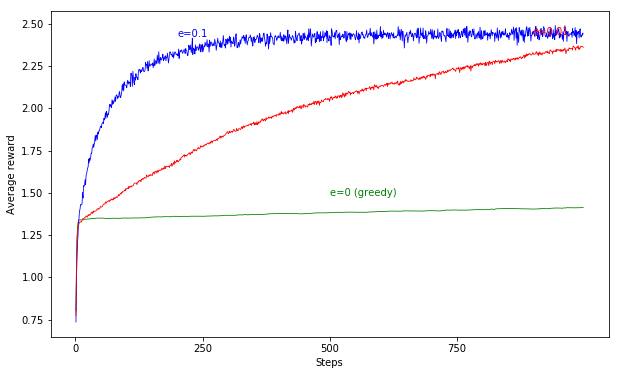

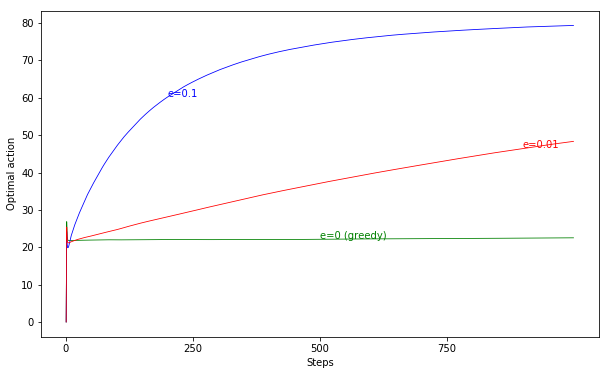

In [38]:
# sample average method
num_run = 2000
steps = 1000

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                         action_policy='greedy', method='sample-average')
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                           action_policy='e-greedy', method='sample-average', epsilon=0.1)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                             action_policy='e-greedy', method='sample-average', epsilon=0.01)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)

draw_step_reward(time_steps)
draw_step_optimal_action(time_steps)

## Nonstationary bandits by Incremental Method

starts running bandits : 2018-07-21 22:38:37.399890
finished running bandits : 2018-07-21 22:42:39.901780


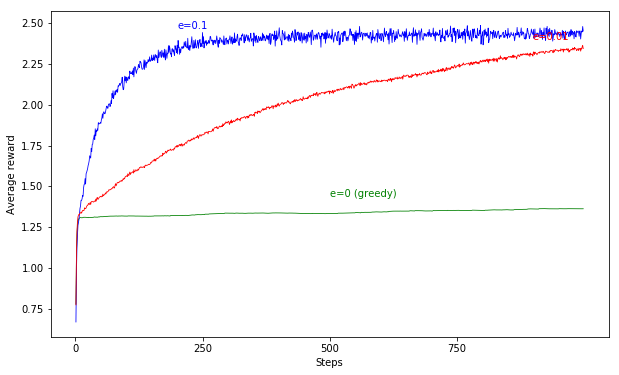

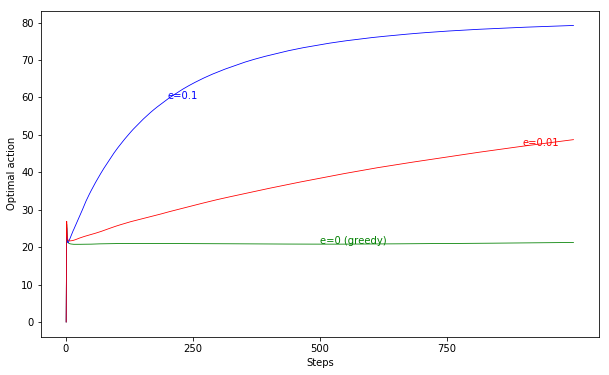

In [39]:
# incremental method
num_run = 2000

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                         action_policy='greedy', method='incremental')
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                           action_policy='e-greedy', method='incremental', epsilon=0.1)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                             action_policy='e-greedy', method='incremental', epsilon=0.01)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)

draw_step_reward(time_steps)
draw_step_optimal_action(time_steps)

## Nonstationary bandits by Constant Step-Size Method

starts running bandits : 2018-07-21 22:42:40.389627
finished running bandits : 2018-07-21 22:46:40.028545


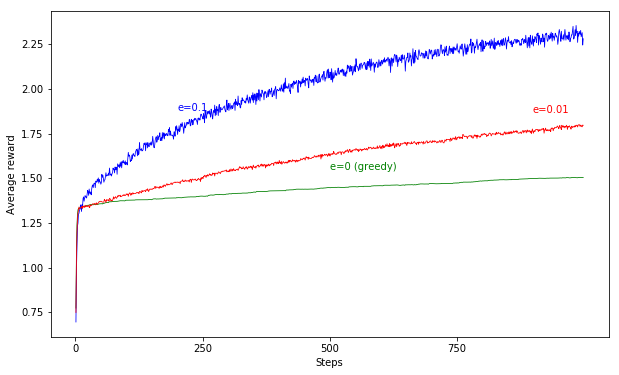

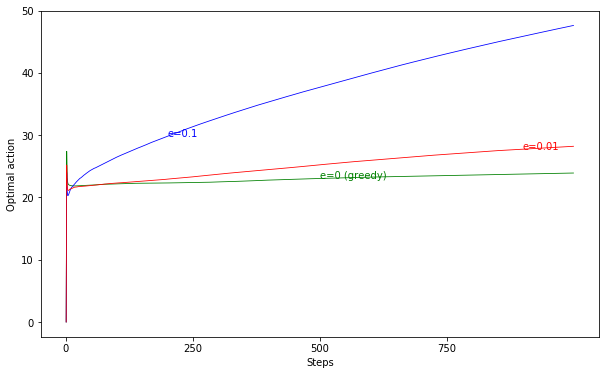

In [40]:
# constant step-size method
num_run = 2000
steps = 1000
alpha = 0.1 # step size

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                         action_policy='greedy', method='constant-step-size',
                                                         step_size=alpha)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                           action_policy='e-greedy', method='constant-step-size',
                                                           step_size=alpha, epsilon=0.1)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                             action_policy='e-greedy', method='constant-step-size',
                                                             step_size=alpha, epsilon=0.01)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)

draw_step_reward(time_steps)
draw_step_optimal_action(time_steps)

## ε = 0.1 and longer runs, say of 10,000 steps

In [41]:
# constant step-size method, ε = 0.1 and 10,000 steps
num_run = 2000
steps = 10000
alpha = 0.1 # step size

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                         action_policy='greedy', method='constant-step-size',
                                                         step_size=alpha)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                           action_policy='e-greedy', method='constant-step-size',
                                                           step_size=alpha, epsilon=0.1)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run(k, q_stars, nr_dist, steps,
                                                             action_policy='e-greedy', method='constant-step-size',
                                                             step_size=alpha, epsilon=0.01)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)


starts running bandits : 2018-07-21 22:46:40.490404
finished running bandits : 2018-07-21 23:32:25.901147


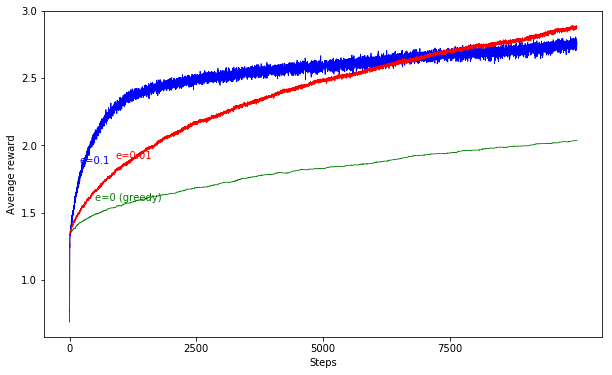

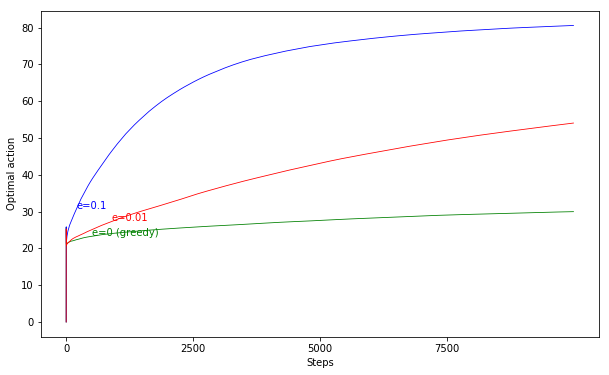

In [42]:
# epsilon with 0.01 makes better reward in the long run
draw_step_reward(steps)
draw_step_optimal_action(steps)

# 2.6 Optimistic Initial Values

## Figure 2.3
The effect of optimistic initial action-value estimates on the 10-armed testbed. Both methods used a constant step-size parameter, α = 0.1.

In [43]:
# Figure 2.3

# Exercise 2.5

def nonstationary_run_with_opt_init(k, q_stars, r_dist, time_steps, action_policy='greedy', method='incremental',
                                    std=0.01, epsilon=0.0, step_size=0.0, init_value=10.0) :  
    # initialize
    n_taken = np.zeros(k, np.int32) # N(a) in the text
    values = np.full(k, init_value, np.float32) # Q(a) in the text
    if method == 'sample-average' :
        sum_rewards = np.zeros(k, np.float32)

    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)

    # nonstationary bandit state simulation.
    # pre-determine each time step states for calculation performance
    bandit_trials = build_nonstationary_bandits(k, q_stars, r_dist, time_steps, std)

    # explore_count = 0
    optimal_count = 0
    if action_policy == 'e-greedy' :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * epsilon))

    for t in range(time_steps) :
        # action selection by policy
        if action_policy == 'e-greedy' :
            if t in explore_steps :
                # explore_count = explore_count + 1
                lever = np.random.randint(0, k)
            else :
                lever = select_greedy2(values)
        else : # default is greedy
            lever = select_greedy2(values)
        reward = bandit_trials[lever, t] # R <- bandit(A) in the text. A is the selected lever
        
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        n_taken[lever] = n_taken[lever] + 1 # N(A) <- N(A) + 1 in the text

        if method == 'sample-average' :
            # calculate action-values by sample_average method
            sum_rewards[lever] = sum_rewards[lever] + reward
            values[lever] = sum_rewards[lever] / n_taken[lever]
        elif method == 'constant-step-size' :
            # calculate action-values by constant step-size method
            values[lever] = values[lever] + (reward - values[lever]) * step_size            
        elif method == 'incremental' :
            # calculate action-values by incremental method
            values[lever] = values[lever] + (reward - values[lever]) / n_taken[lever]
        else :
            raise ValueError('Unknown method :' + method)
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

## Nonstationary bandits by Sample Average Method with Optimistic Initial Values

starts running bandits : 2018-07-21 23:32:26.988687
finished running bandits : 2018-07-21 23:37:11.788368


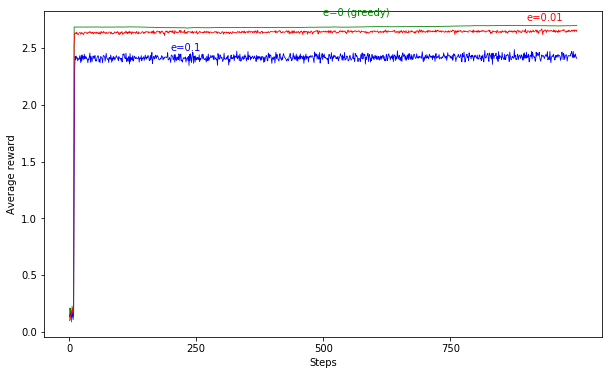

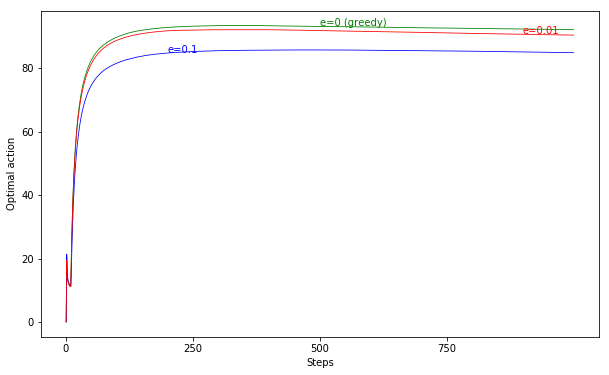

In [44]:
# sample average method
num_run = 2000
steps = 1000

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                       action_policy='greedy', method='sample-average',
                                                                       init_value=5.0)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                         action_policy='e-greedy', method='sample-average',
                                                                         epsilon=0.1, init_value=5.0)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                           action_policy='e-greedy', method='sample-average',
                                                                           epsilon=0.01, init_value=5.0)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)

draw_step_reward(steps)
draw_step_optimal_action(steps)

## Nonstationary bandits by Incremental Method with Optimistic Initial Values

starts running bandits : 2018-07-21 23:37:12.296785
finished running bandits : 2018-07-21 23:41:35.124001


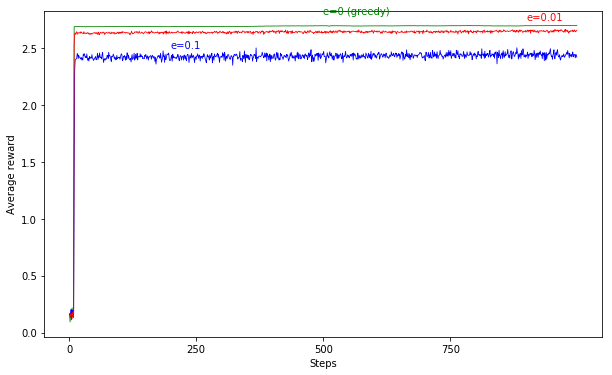

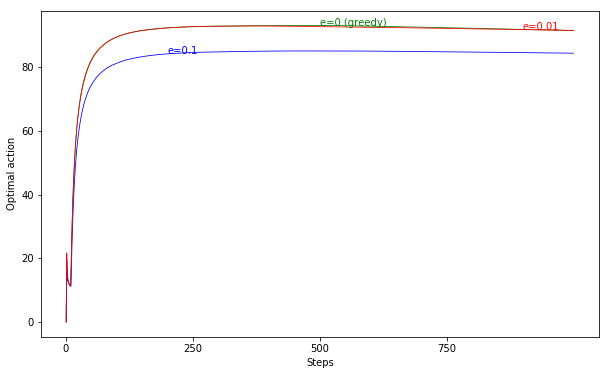

In [45]:
# incremental method
num_run = 2000

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                       action_policy='greedy', method='incremental',
                                                                       init_value=5.0)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                         action_policy='e-greedy', method='incremental',
                                                                         epsilon=0.1, init_value=5.0)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                           action_policy='e-greedy', method='incremental',
                                                                           epsilon=0.01, init_value=5.0)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)

draw_step_reward(steps)
draw_step_optimal_action(steps)

## Nonstationary bandits by Constant Step-Size Method with Optimistic Initial Values

starts running bandits : 2018-07-21 23:41:35.614333
finished running bandits : 2018-07-21 23:46:10.705116


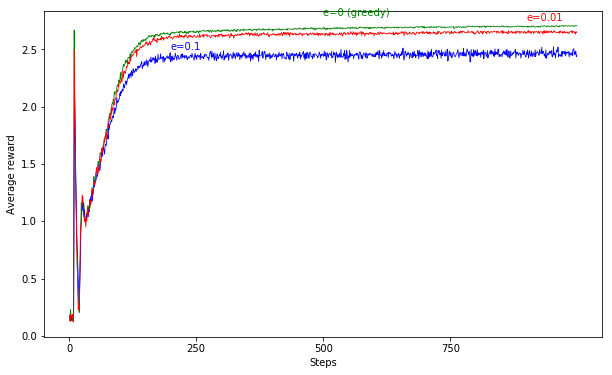

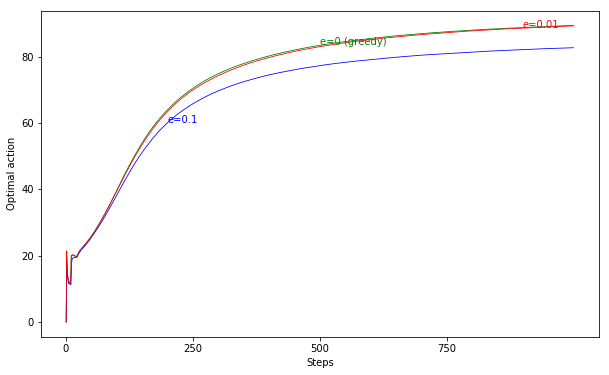

In [46]:
# constant step-size method
num_run = 2000
steps = 1000
alpha = 0.1 # step size

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                       action_policy='greedy', method='constant-step-size',
                                                                       step_size=alpha, init_value=5.0)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                         action_policy='e-greedy', method='constant-step-size',
                                                                         step_size=alpha, epsilon=0.1, init_value=5.0)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                           action_policy='e-greedy', method='constant-step-size',
                                                                           step_size=alpha, epsilon=0.01, init_value=5.0)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)

draw_step_reward(steps)
draw_step_optimal_action(steps)

## ε = 0.1 and longer runs, say of 10,000 steps with Optimistic Initial Values

In [47]:
# constant step-size method, ε = 0.1 and 10,000 steps
num_run = 2000
steps = 10000
alpha = 0.1 # step size

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                       action_policy='greedy', method='constant-step-size',
                                                                       step_size=alpha, init_value=5.0)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                         action_policy='e-greedy', method='constant-step-size',
                                                                         step_size=alpha, epsilon=0.1, init_value=5.0)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run_with_opt_init(k, q_stars, nr_dist, steps,
                                                                           action_policy='e-greedy', method='constant-step-size',
                                                                           step_size=alpha, epsilon=0.01, init_value=5.0)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)


starts running bandits : 2018-07-21 23:46:11.217758
finished running bandits : 2018-07-22 00:31:48.047889


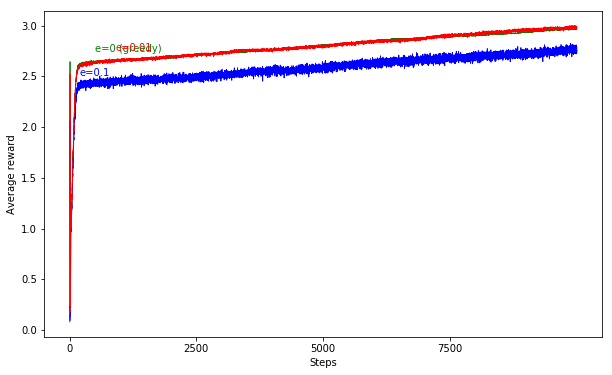

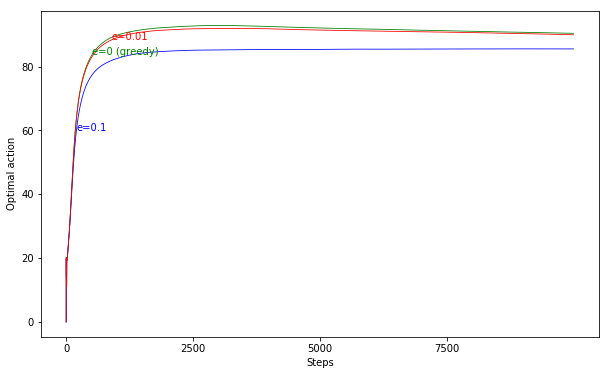

In [48]:
# epsilon with 0.01 makes better reward in the long run
draw_step_reward(steps)
draw_step_optimal_action(steps)

## Exercise 2.7 Unbiased Constant-Step-Size Trick

In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems?

One way is to use a step size of
βn =. α/o ̄n, (2.8) to process the nth reward for a particular action, where α > 0 is a conventional constant
step size, and o ̄n is a trace of one that starts at 0:


o ̄n=.o ̄n−1+α(1−o ̄n−1), forn≥0, witho ̄0=.0. (2.9)


Carry out an analysis like that in (2.6) to show that Qn is an exponential recency-weighted average without initial bias.

In [110]:
# Exercise 2.7 : Unbiased Constant-Step-Size Trick
# enhance to avoid initial value bias from constant step size

def nonstationary_run_with_opt_init2(k, q_stars, r_dist, time_steps, action_policy='greedy', method='incremental',
                                     std=0.01, epsilon=0.0, step_size=0.0, init_value=10.0) :  
    # initialize
    n_taken = np.zeros(k, np.int32) # N(a) in the text
    values = np.full(k, init_value, np.float32) # Q(a) in the text
    if method == 'sample-average' :
        sum_rewards = np.zeros(k, np.float32)
    elif method == 'unbiased-constant-step-size' :
        unbias_trace_factor = 1e-7 # o ̄n. to avoid divide by zero, take a sufficiently small value

    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)

    # nonstationary bandit state simulation.
    # pre-determine each time step states for calculation performance
    bandit_trials = build_nonstationary_bandits(k, q_stars, r_dist, time_steps, std)

    # explore_count = 0
    optimal_count = 0
    if action_policy == 'e-greedy' :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * epsilon))

    for t in range(time_steps) :
        # action selection by policy
        if action_policy == 'e-greedy' :
            if t in explore_steps :
                # explore_count = explore_count + 1
                lever = np.random.randint(0, k)
            else :
                lever = select_greedy2(values)
        else : # default is greedy
            lever = select_greedy2(values)
        reward = bandit_trials[lever, t] # R <- bandit(A) in the text. A is the selected lever
        
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        n_taken[lever] = n_taken[lever] + 1 # N(A) <- N(A) + 1 in the text

        if method == 'sample-average' :
            # calculate action-values by sample_average method
            sum_rewards[lever] = sum_rewards[lever] + reward
            values[lever] = sum_rewards[lever] / n_taken[lever]
        elif method == 'constant-step-size' :
            # calculate action-values by constant step-size method
            values[lever] = values[lever] + (reward - values[lever]) * step_size            
        elif method == 'unbiased-constant-step-size' :
            # calculate action-values by constant step-size method
            if t == 0 :
                values[lever] = values[lever] + (reward - values[lever]) * step_size
            else :
                values[lever] = values[lever] + (reward - values[lever]) * step_size / unbias_trace_factor
            # print('step', t, ', values = ', values, ', unbias factor = ', unbias_trace_factor)
            unbias_trace_factor = unbias_trace_factor + step_size * (1.0 - unbias_trace_factor) 
        elif method == 'incremental' :
            # calculate action-values by incremental method
            values[lever] = values[lever] + (reward - values[lever]) / n_taken[lever]
        else :
            raise ValueError('Unknown method :' + method)
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

starts running bandits : 2018-08-09 14:07:01.267129
finished running bandits : 2018-08-09 14:11:13.810388


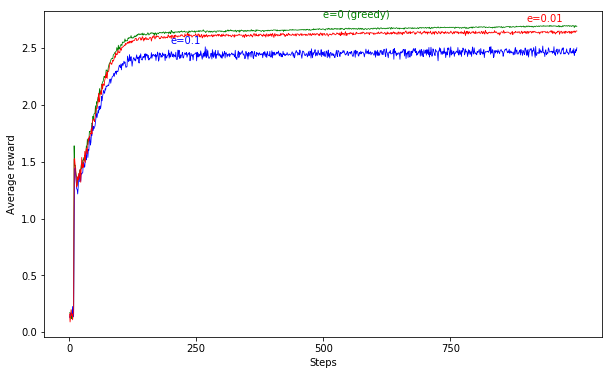

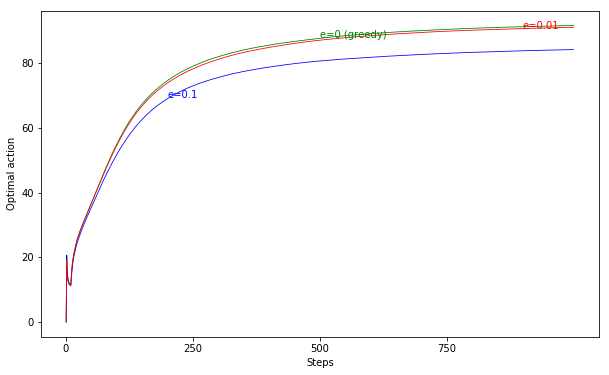

In [111]:
# unbiased constant step-size method
num_run = 2000
steps = 1000
alpha = 0.1 # step size

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run_with_opt_init2(k, q_stars, nr_dist, steps,
                                                                       action_policy='greedy', method='unbiased-constant-step-size',
                                                                       step_size=alpha, init_value=5.0)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run_with_opt_init2(k, q_stars, nr_dist, steps,
                                                                         action_policy='e-greedy', method='unbiased-constant-step-size',
                                                                         step_size=alpha, epsilon=0.1, init_value=5.0)
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run_with_opt_init2(k, q_stars, nr_dist, steps,
                                                                           action_policy='e-greedy', method='unbiased-constant-step-size',
                                                                           step_size=alpha, epsilon=0.01, init_value=5.0)
    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)

draw_step_reward(steps)
draw_step_optimal_action(steps)

# 2.7 Upper-Confidence-Bound Action Selection

The idea of this upper confidence bound (UCB) action selection is that the square-root term is a measure of the uncertainty or variance in the estimate of a’s value. The quantity being max’ed over is thus a sort of upper bound on the possible true value of action a, with c determining the confidence level. Each time a is selected the uncertainty is presumably reduced: Nt(a) increments, and, as it appears in the denominator, the uncertainty term decreases. On the other hand, each time an action other than a is selected, t increases but Nt(a) does not; because t appears in the numerator, the uncertainty estimate increases. The use of the natural logarithm means that the increases get smaller over time, but are unbounded; all actions will eventually be selected, but actions with lower value estimates, or that have already been selected frequently, will be selected with decreasing frequency over time.

In [5]:
# Figure 2.4

def nonstationary_run_with_opt_init3(k, q_stars, r_dist, time_steps, action_policy='greedy', method='incremental',
                                     std=0.01, arg=0.0, step_size=0.0, init_value=10.0) :  
    # initialize
    n_taken = np.zeros(k, np.int32) # N(a) in the text
    values = np.full(k, init_value, np.float32) # Q(a) in the text
    if method == 'sample-average' :
        sum_rewards = np.zeros(k, np.float32)
    elif method == 'unbiased-constant-step-size' :
        unbias_trace_factor = 1e-7 # o ̄n. to avoid divide by zero, take a sufficiently small value

    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)

    # nonstationary bandit state simulation.
    # pre-determine each time step states for calculation performance
    bandit_trials = build_nonstationary_bandits(k, q_stars, r_dist, time_steps, std)

    # explore_count = 0
    optimal_count = 0
    if action_policy == 'e-greedy' :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * arg))

    for t in range(time_steps) :
        # action selection by policy
        if action_policy == 'e-greedy' :
            if t in explore_steps :
                # explore_count = explore_count + 1
                lever = np.random.randint(0, k)
            else :
                lever = select_greedy2(values)
        elif action_policy == 'ucb' :
            if t == 0 : # nothing has selected
                lever = select_greedy2(values)
            else :
                n_taken_adjusted = n_taken.astype(np.float32)
                n_taken_adjusted[n_taken_adjusted == 0.0] = 1e-7 # to avoid nan (divide by zero)
                lever = select_greedy2(values + arg * np.sqrt(np.log(t) / n_taken_adjusted))
        else : # default is greedy
            lever = select_greedy2(values)
        reward = bandit_trials[lever, t] # R <- bandit(A) in the text. A is the selected lever
        
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        n_taken[lever] = n_taken[lever] + 1 # N(A) <- N(A) + 1 in the text

        if method == 'sample-average' :
            # calculate action-values by sample_average method
            sum_rewards[lever] = sum_rewards[lever] + reward
            values[lever] = sum_rewards[lever] / n_taken[lever]
        elif method == 'constant-step-size' :
            # calculate action-values by constant step-size method
            values[lever] = values[lever] + (reward - values[lever]) * step_size            
        elif method == 'unbiased-constant-step-size' :
            # calculate action-values by constant step-size method
            if t == 0 :
                values[lever] = values[lever] + (reward - values[lever]) * step_size
            else :
                values[lever] = values[lever] + (reward - values[lever]) * step_size / unbias_trace_factor
            # print('step', t, ', values = ', values, ', unbias factor = ', unbias_trace_factor)
            unbias_trace_factor = unbias_trace_factor + step_size * (1.0 - unbias_trace_factor) 
        elif method == 'incremental' :
            # calculate action-values by incremental method
            values[lever] = values[lever] + (reward - values[lever]) / n_taken[lever]
        else :
            raise ValueError('Unknown method :' + method)
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

In [113]:
# unbiased constant step-size method and ucb action policy
num_run = 2000
steps = 1000
alpha = 0.1 # step size

n_avg_rs_e0 = np.empty(num_run, dtype=object)
n_avg_rs_e01 = np.empty(num_run, dtype=object)
n_avg_rs_e001 = np.empty(num_run, dtype=object)
n_avg_rs_ucb = np.empty(num_run, dtype=object)

n_opt_acts_e0 = np.empty(num_run, dtype=object)
n_opt_acts_e01 = np.empty(num_run, dtype=object)
n_opt_acts_e001 = np.empty(num_run, dtype=object)
n_opt_acts_ucb = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_e0[i], n_opt_acts_e0[i] = nonstationary_run_with_opt_init3(k, q_stars, nr_dist, steps,
                                                                       action_policy='greedy', method='unbiased-constant-step-size',
                                                                       step_size=alpha, init_value=5.0)
    n_avg_rs_e01[i], n_opt_acts_e01[i] = nonstationary_run_with_opt_init3(k, q_stars, nr_dist, steps,
                                                                         action_policy='e-greedy', method='unbiased-constant-step-size',
                                                                         step_size=alpha, arg=0.1, init_value=5.0) # arg is epsilon
    n_avg_rs_e001[i], n_opt_acts_e001[i] = nonstationary_run_with_opt_init3(k, q_stars, nr_dist, steps,
                                                                           action_policy='e-greedy', method='unbiased-constant-step-size',
                                                                           step_size=alpha, arg=0.01, init_value=5.0) # arg is epsilon
    n_avg_rs_ucb[i], n_opt_acts_ucb[i] = nonstationary_run_with_opt_init3(k, q_stars, nr_dist, steps,
                                                                           action_policy='ucb', method='unbiased-constant-step-size',
                                                                           step_size=alpha, arg=2.0, init_value=5.0) # arg is c value

    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_e0 = np.mean(np.stack(n_avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(n_avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(n_avg_rs_e001), axis=0)
m_avg_rs_ucb = np.mean(np.stack(n_avg_rs_ucb), axis=0)

m_opt_acts_e0 = np.mean(np.stack(n_opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(n_opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(n_opt_acts_e001), axis=0)
m_opt_acts_ucb = np.mean(np.stack(n_opt_acts_ucb), axis=0)


starts running bandits : 2018-08-09 14:11:14.450634
finished running bandits : 2018-08-09 14:17:09.359239


In [114]:
# draw steps - average reward 2

def draw_step_reward2(time_steps) :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    x_interval = time_steps // 4
    ax.set_xticks([x for x in range(0, time_steps, x_interval)])
    ax.set_xticklabels([x for x in range(0, time_steps, x_interval)])

    x_axis = np.array(range(1, time_steps))
    ax.plot(x_axis, m_avg_rs_e0[1:], color='g', lw=0.8, label='greedy')
    ax.text(500, m_avg_rs_e0[500] + 0.1, 'greedy', color='g')

    ax.plot(x_axis, m_avg_rs_e01[1:], color='grey', lw=0.8, label='e-greedy (e=0.1)')
    ax.text(200, m_avg_rs_e01[200] + 0.1, 'e-greedy e=0.1', color='grey')

    ax.plot(x_axis, m_avg_rs_e001[1:], color='r', lw=0.8, label='e-greedy (e=0.01)')
    ax.text(900, m_avg_rs_e001[900] + 0.1, 'e-greedy e=0.01', color='r')

    ax.plot(x_axis, m_avg_rs_ucb[1:], color='b', lw=0.8, label='UCB (c=2)')
    ax.text(250, m_avg_rs_ucb[250] + 0.1, 'UCB c=2', color='b')
    
    ax.set_xlabel('Steps')
    ax.set_ylabel('Average reward')

    plt.show()

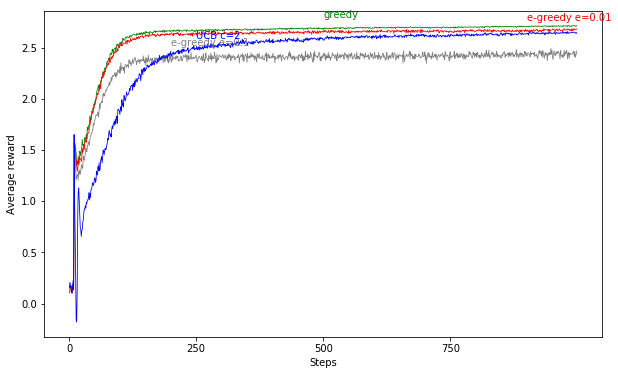

In [115]:
draw_step_reward2(steps)

Figure 2.4 (above): Average performance of UCB action selection on the 10-armed testbed. As shown, UCB generally performs better than ε-greedy action selection, except in the first k steps, when it selects randomly among the as-yet-untried actions.

Unsolved Question : why UCB with c=2 performs worse than e-greedy with e=0.01? although it performed better than e-greedy with e=0.1

# 2.8 Gradient Bandit Algorithms

do not estimate action value, rather use numerical preference for each actions

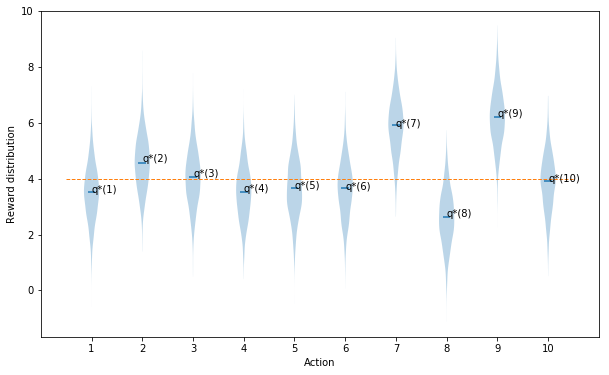

In [56]:
# create and save bandit machines

# q_stars_m4 will be the action value of each lever selection (now, bandit machine is made !!!)
q_stars_m4 = np.array(q_stars) + 4.0

r_dist_m4 = [np.random.normal(q_stars_m4[t], 1.0, 2000) for t in range(k)]

# save generated bandit
pk.dump((q_stars_m4, r_dist_m4), open('10-armed-m4.p', "wb" ))

draw_bandits(q_stars_m4, r_dist_m4, mean=4.0)


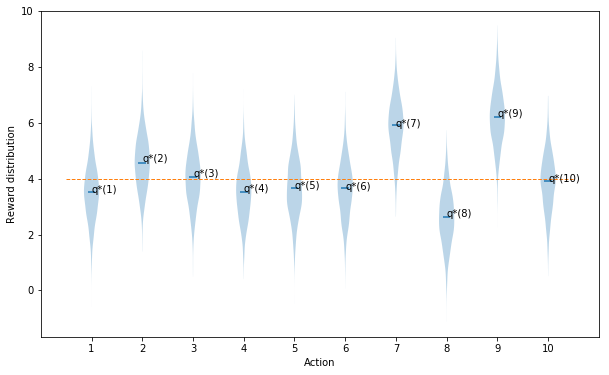

In [6]:
import pickle as pk

# load saved bandit machines

q_stars_m4, r_dist_m4 = pk.load(open('10-armed-m4.p', "rb"))

draw_bandits(q_stars_m4, r_dist_m4, mean=4.0)


In [7]:
nr_dist_m4 = np.stack(r_dist_m4)

In [32]:
# Figure 2.5
import math

def calculate_pref(action, action_prefs, exp_action_prefs) :
    val = exp_action_prefs[action] / np.sum(exp_action_prefs)
    if val is None or math.isnan(val) or np.isinf(val) :
        raise ValueError('Invalid value :' + str(exp_action_prefs) + ', val:' + str(val) + ', list:' + str(action_prefs) + ', sum:' + str(np.sum(exp_action_prefs)))
    return val
    
def nonstationary_run_with_gradient_bandit(k, q_stars, r_dist, time_steps,
                                           std=0.01, epsilon=0.1,
                                           step_size=0.0, init_value=0.0,
                                           no_baseline=False) :
    # initialize
    n_taken = np.zeros(k, np.int32) # N(a) in the text
    reward_avg = 0.0 # R bar in the text
    action_prefs = np.full(k, init_value, np.float32) # H(a) in the text
    max_action_pref = 10.0 # do not grow above limit
    min_action_pref = -5.0 # do not shrink below limit

    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)
    unbias_trace_factor = 1e-7 # o ̄n. to avoid divide by zero, take a sufficiently small value

    # nonstationary bandit state simulation.
    # pre-determine each time step states for calculation performance
    bandit_trials = build_nonstationary_bandits(k, q_stars, r_dist, time_steps, std)

    # explore_count = 0
    optimal_count = 0
    if epsilon == 0 :
        explore_steps = []
    else :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * epsilon))

    for t in range(time_steps) :
        # action selection by policy
        if t in explore_steps :
            # explore_count = explore_count + 1
            lever = np.random.randint(0, k)
        else :
            lever = select_greedy2(action_prefs)
            
        reward = bandit_trials[lever, t] # R <- bandit(A) in the text. A is the selected lever

        if not no_baseline : # in case of baseline, R bar is given as a constant zero
            # 'unbiased-constant-step-size' :
            # calculate action-values by constant step-size method (non-stationary model)
            prev_reward_avg = reward_avg
            if t == 0 :
                reward_avg = reward_avg + (reward - reward_avg) * step_size
            else :
                reward_avg = reward_avg + (reward - reward_avg) * step_size / unbias_trace_factor
                
            if reward_avg is None or math.isnan(reward_avg) or np.isinf(reward_avg) :
                raise ValueError('Invalid value :' + str(reward_avg) + ', prev:' + str(prev_reward_avg) + ', reward:' + str(reward) + ', unbias_trace:' + str(unbias_trace_factor) + ', step_size:' + str(step_size)) 

            # print('step', t, ', values = ', values, ', unbias factor = ', unbias_trace_factor)
            prev_factor = unbias_trace_factor
            unbias_trace_factor = unbias_trace_factor + step_size * (1.0 - unbias_trace_factor) 
            if unbias_trace_factor is None or math.isnan(unbias_trace_factor) or np.isinf(unbias_trace_factor) or unbias_trace_factor == 0.0 :
                unbias_trace_factor = prev_factor # just not to make problem ...
    
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        exp_action_prefs = np.exp(action_prefs)
        
        for a in range(k) :
            if a == lever :
                action_prefs[a] = action_prefs[a] + step_size * (reward - reward_avg) * (1 - calculate_pref(a, action_prefs, exp_action_prefs))
            else :
                action_prefs[a] = action_prefs[a] - step_size * (reward - reward_avg) * calculate_pref(a, action_prefs, exp_action_prefs)
            if action_prefs[a] > max_action_pref : # give an upper bound to avoid explosion
                action_prefs[a] = max_action_pref
            elif action_prefs[a] < min_action_pref : # give an lower bound to avoid explosion
                action_prefs[a] = min_action_pref
                
            if action_prefs[a] is None or math.isnan(action_prefs[a]) or np.isinf(action_prefs[a]) :
                raise ValueError('Invalid value :' + str(exp_action_prefs) + ', val:' + str(action_prefs[a]) + ', list:' + str(action_prefs) + ', sum:' + str(np.sum(exp_action_prefs)) + ', reward_avg:' + str(reward_avg) + ', reward:' + str(reward)) 

                
        n_taken[lever] = n_taken[lever] + 1 # N(A) <- N(A) + 1 in the text
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

In [17]:
# unbiased constant step-size method and ucb action policy
num_run = 2000
steps = 1000

n_avg_rs_a01_nb = np.empty(num_run, dtype=object)
n_avg_rs_a04_nb = np.empty(num_run, dtype=object)
n_avg_rs_a01_m4 = np.empty(num_run, dtype=object)
n_avg_rs_a04_m4 = np.empty(num_run, dtype=object)

n_opt_acts_a01_nb = np.empty(num_run, dtype=object)
n_opt_acts_a04_nb = np.empty(num_run, dtype=object)
n_opt_acts_a01_m4 = np.empty(num_run, dtype=object)
n_opt_acts_a04_m4 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    n_avg_rs_a01_nb[i], n_opt_acts_a01_nb[i] = nonstationary_run_with_gradient_bandit(k, q_stars_m4, nr_dist_m4,
                                                                                      steps, step_size=0.1, no_baseline=True)
    n_avg_rs_a04_nb[i], n_opt_acts_a04_nb[i] = nonstationary_run_with_gradient_bandit(k, q_stars_m4, nr_dist_m4,
                                                                                      steps, step_size=0.4, no_baseline=True)
    n_avg_rs_a01_m4[i], n_opt_acts_a01_m4[i] = nonstationary_run_with_gradient_bandit(k, q_stars_m4, nr_dist_m4,
                                                                                      steps, step_size=0.1)
    n_avg_rs_a04_m4[i], n_opt_acts_a04_m4[i] = nonstationary_run_with_gradient_bandit(k, q_stars_m4, nr_dist_m4,
                                                                                      steps, step_size=0.4)


    
print('finished running bandits :', dt.datetime.now())

# get average of the 2000 runs
m_avg_rs_a01_nb = np.mean(np.stack(n_avg_rs_a01_nb), axis=0) # (num_run, time_steps)
m_avg_rs_a04_nb = np.mean(np.stack(n_avg_rs_a04_nb), axis=0)
m_avg_rs_a01_m4 = np.mean(np.stack(n_avg_rs_a01_m4), axis=0)
m_avg_rs_a04_m4 = np.mean(np.stack(n_avg_rs_a04_m4), axis=0)

m_opt_acts_a01_nb = np.mean(np.stack(n_opt_acts_a01_nb), axis=0)
m_opt_acts_a04_nb = np.mean(np.stack(n_opt_acts_a04_nb), axis=0)
m_opt_acts_a01_m4 = np.mean(np.stack(n_opt_acts_a01_m4), axis=0)
m_opt_acts_a04_m4 = np.mean(np.stack(n_opt_acts_a04_m4), axis=0)

starts running bandits : 2018-08-10 15:42:56.998743
finished running bandits : 2018-08-10 16:17:47.763306


In [18]:
# draw steps - optimal action

def draw_step_optimal_action2(time_steps) :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    x_interval = time_steps // 4
    ax.set_xticks([x for x in range(0, time_steps, x_interval)])
    ax.set_xticklabels([x for x in range(0, time_steps, x_interval)])

    x_axis = np.array(range(1, time_steps + 1))
    ax.plot(x_axis, m_opt_acts_a01_nb, color='b', lw=0.8, label='alpha=0.1')
    ax.text(200, m_opt_acts_a01_nb[200], 'a=0.1 (without baseline)', color='b')

    ax.plot(x_axis, m_opt_acts_a04_nb, color='cyan', lw=0.8, label='alpha=0.4')
    ax.text(800, m_opt_acts_a04_nb[800], 'a=0.4 (without baseline)', color='cyan')

    ax.plot(x_axis, m_opt_acts_a01_m4, color='brown', lw=0.8, label='alpha=0.1')
    ax.text(200, m_opt_acts_a01_m4[200], 'a=0.1 (with baseline)', color='brown')

    ax.plot(x_axis, m_opt_acts_a04_m4, color='gold', lw=0.8, label='alpha=0.4')
    ax.text(800, m_opt_acts_a04_m4[800], 'a=0.4 (with baseline)', color='gold')    
    
    ax.set_xlabel('Steps')
    ax.set_ylabel('Optimal action (%)')

    plt.show()



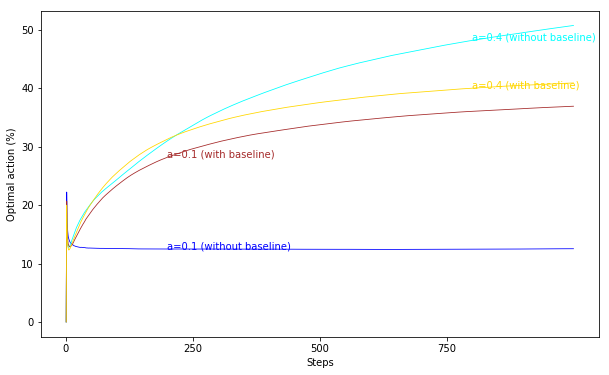

In [19]:
draw_step_optimal_action2(steps)

### Unsolved Questions 
step size 0.4 without baseline works best. why? :-(

# 2.10 Summary

## parameter study
The ε-greedy methods choose randomly a small fraction of the time, whereas UCB methods choose deterministically but achieve exploration by subtly favoring at each step the actions that have so far received fewer samples. Gradient bandit algorithms estimate not action values, but action preferences, and favor the more preferred actions in a graded, probabilistic manner using a soft-max distribution. The simple expedient of initializing estimates optimistically causes even greedy methods to explore significantly.

In [118]:
# Figure 2.6 (Exercise 2.11)

# unbiased constant step-size method
num_run = 2000
steps = 1000
alpha = 0.1 # step size

n_avg_rs_e0a1 = np.empty(num_run, dtype=object) # greedy with optimistic initialization, alpha = 0.1, init_value=5.0
n_avg_rs_e01a1 = np.empty(num_run, dtype=object) # e-greedy with constant-step-size alpha = 0.1
n_avg_rs_ucb = np.empty(num_run, dtype=object) # 'ucb' action_policy
n_avg_rs_grad = np.empty(num_run, dtype=object) # gradient bandit

n_opt_acts_e0a1 = np.empty(num_run, dtype=object)
n_opt_acts_e01a1 = np.empty(num_run, dtype=object)
n_opt_acts_ucb = np.empty(num_run, dtype=object)
n_opt_acts_grad = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)

e0a1_init_values = [ 0.25, 0.5, 1.0, 2.0, 4.0 ]
e01a1_epsilons = [ 1.0 / 128.0, 1.0 / 64.0, 1.0 / 32.0, 1.0 / 16.0, 1.0 / 8.0, 1.0 / 4.0 ]
ucb_step_sizes = [ 1.0 / 16.0, 1.0 / 8.0, 1.0 / 4.0, 1.0 / 2.0, 1.0, 2.0, 4.0]
grad_step_sizes = [ 1.0 / 32.0, 1.0 / 16.0, 1.0 / 8.0, 1.0 / 4.0, 1.0 / 2.0, 1.0, 2.0, 4.0]

e0a1_rs = []
e01a1_rs = []

for i in range(len(e0a1_init_values)) :
    for j in range(num_run) :
        n_avg_rs_e0a1[j], n_opt_acts_e0a1[j] = nonstationary_run_with_opt_init3(k, q_stars, nr_dist, steps,
                                                                               action_policy='greedy', method='unbiased-constant-step-size',
                                                                               step_size=alpha, init_value=e0a1_init_values[i])
        n_avg_rs_e0a1[j] = np.mean(np.vstack(n_avg_rs_e0a1[j]))
    e0a1_rs.append(np.mean(n_avg_rs_e0a1))

for i in range(len(e01a1_epsilons)) :
    for j in range(num_run) :
        n_avg_rs_e01a1[j], n_opt_acts_e01a1[j] = nonstationary_run_with_opt_init3(k, q_stars, nr_dist, steps,
                                                                             action_policy='e-greedy', method='unbiased-constant-step-size',
                                                                             step_size=alpha, arg=e01a1_epsilons[i], init_value=5.0)
        n_avg_rs_e01a1[j] = np.mean(np.vstack(n_avg_rs_e01a1[j]))
    e01a1_rs.append(np.mean(n_avg_rs_e01a1))

print(e0a1_rs)
print(e01a1_rs)
print('finished running bandits :', dt.datetime.now())

starts running bandits : 2018-08-11 17:26:56.584154
[1.6520052, 1.7923298, 2.2074552, 2.5712276, 2.637162]
[2.5387428, 2.550685, 2.5183747, 2.4487689, 2.2904866, 1.9827826]
finished running bandits : 2018-08-11 17:43:44.386219


In [120]:
print('starts running bandits (part 2) :', dt.datetime.now())

ucb_rs = []

for i in range(len(ucb_step_sizes)) :
    for j in range(num_run) :    
        n_avg_rs_ucb[j], n_opt_acts_ucb[j] = nonstationary_run_with_opt_init3(k, q_stars, nr_dist, steps,
                                                                           action_policy='ucb', method='unbiased-constant-step-size',
                                                                           step_size=alpha, arg=ucb_step_sizes[i], init_value=5.0)
        n_avg_rs_ucb[j] = np.mean(np.vstack(n_avg_rs_ucb[j]))

    ucb_rs.append(np.mean(n_avg_rs_ucb))

print(ucb_rs)

print('finished running bandits (part 2) :', dt.datetime.now())

starts running bandits (part 2) : 2018-08-11 17:44:13.262867
[2.571425, 2.575275, 2.5422091, 2.5318873, 2.4702904, 2.4282804, 2.2650793]
finished running bandits (part 2) : 2018-08-11 17:57:36.796916


In [121]:
print('starts running bandits (part 3) :', dt.datetime.now())

grad_rs = []

for i in range(len(grad_step_sizes)) :
    for j in range(num_run) :        
        n_avg_rs_grad[j], n_opt_acts_grad[j] = nonstationary_run_with_gradient_bandit(k, q_stars, nr_dist,
                                                                                     steps, step_size=grad_step_sizes[i])
        n_avg_rs_grad[j] = np.mean(np.vstack(n_avg_rs_grad[j]))

    grad_rs.append(np.mean(n_avg_rs_grad))

print(grad_rs)
    
print('finished running bandits (part 3) :', dt.datetime.now())

starts running bandits (part 3) : 2018-08-11 17:57:36.806862
[1.7934887, 1.7762458, 1.818654, 1.859629, 1.8950956, 0.19412139, 0.043974094, 1.5247419]
finished running bandits (part 3) : 2018-08-11 19:12:17.225117


In [122]:
m_e0a1_rs = e0a1_rs
m_e01a1_rs = e01a1_rs
m_ucb_rs = ucb_rs
m_grad_rs = grad_rs


In [123]:
# draw steps (log scale) - average reward

def draw_step_reward_logscale() :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    ax.set_xticks([x for x in range(0, 10)]) # 2**-7 -> 2** 2
    ax.set_xticklabels([ '1/' + str(2 ** (7 - x)) if x < 8 else str(2 ** (x - 8)) for x in range(0, 10)])

    e0a1_offset = 5
    e01a1_offset = 0
    ucb_offset = 3
    grad_offset = 2

    x_axis = np.array(range(e0a1_offset, e0a1_offset + len(m_e0a1_rs)))
    ax.plot(x_axis, m_e0a1_rs, color='black', lw=0.8, label='greedy')
    ax.text(e0a1_offset + 3, m_e0a1_rs[3], 'greedy with optimistic initialization alpha=0.1', color='black')

    x_axis = np.array(range(e01a1_offset, e01a1_offset + len(m_e01a1_rs)))
    ax.plot(x_axis, m_e01a1_rs, color='r', lw=0.8, label='e-greedy')
    ax.text(e01a1_offset + 1, m_e01a1_rs[1], 'e-greedy', color='r')

    x_axis = np.array(range(ucb_offset, ucb_offset + len(m_ucb_rs)))
    ax.plot(x_axis, m_ucb_rs, color='b', lw=0.8, label='UCB')
    ax.text(ucb_offset + 2, m_ucb_rs[2], 'UCB', color='b')

    x_axis = np.array(range(grad_offset, grad_offset + len(m_grad_rs)))
    ax.plot(x_axis, m_grad_rs, color='g', lw=0.8, label='gradient bandit')
    ax.text(grad_offset + 3, m_grad_rs[3], 'gradient bandit', color='g')
    
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Average reward over first 1000 steps')

    plt.show()

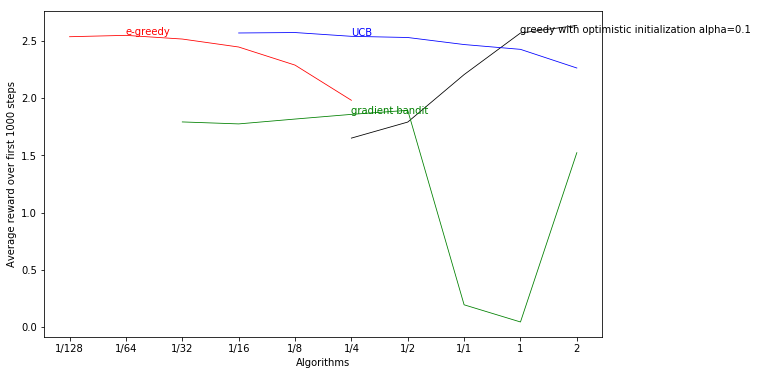

In [124]:
draw_step_reward_logscale()

### Unsolved Questions

why the graph look quite different from that of the text ? :-(

maybe the gradient bandits with parameter 2.0 will due to the lower bounding logic added to prevent -inf.